<a href="https://colab.research.google.com/github/MohammadAghaei1/Plantdoc-image-processing/blob/main/Plantdoc.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Importing Dataset**

In [5]:
!git clone https://github.com/MohammadAghaei1/Plantdoc-image-processing

fatal: destination path 'Plantdoc-image-processing' already exists and is not an empty directory.


In [6]:
!unzip /content/Plantdoc-image-processing/Dataset/PlantDoc\ 416x416.zip

Archive:  /content/Plantdoc-image-processing/Dataset/PlantDoc 416x416.zip
 extracting: train/Faske%20Southern%20rust%20of%20corn_jpg.rf.016116db58617610bb259b2965f41589.jpg  
 extracting: train/Slide1_preview_jpg.rf.00f57cfc188631c10e10e2b93a38d296.jpg  
 extracting: train/2017-08-27%2B-%2BLate%2BBlight%2Bon%2BGypsy%2B1_jpg.rf.00584c9d14b6fda3086f9a482675d610.jpg  
 extracting: train/Apple-Scab-image-02_jpg.rf.00cbc9a108dbdaadf4232b5392e3d3c8.jpg  
 extracting: train/24154194959_fd4b42edde_b_jpg.rf.0012f9978a300c5635840700fa784280.jpg  
 extracting: train/2-3%20Gray%20leaf%20spot%20BRUCE_jpg.rf.0040c2e382cf11216938e6f49b7d65ed.jpg  
 extracting: train/Septoria_tomato_Margaret%20B_p8170755_0002_25004_jpg.rf.00ddfef2668a53da256f207f9b844782.jpg  
 extracting: train/d-to-tylv-fo005-14496A31BE70553130A_jpg.rf.017e4558f1b4baeadc32a13beb178a6e.jpg  
 extracting: train/Bacterial-spot-symptoms-on-pepper-leaves-for-web_jpg.rf.01bc16f3b7ba0e4c9fa8c07133a723c6.jpg  
 extracting: train/IMG_6029-00

In [7]:
import os
import csv
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt

# **Data Preparation**

In [8]:
annotation_path = '/content/train/_annotations.csv'

In [9]:
problematic_lines = []
expected_cols = 8

with open(annotation_path, 'r') as f:
    reader = csv.reader(f)
    # Skip the header row
    header = next(reader)
    for i, row in enumerate(reader):
        if len(row) != expected_cols:
            problematic_lines.append((i + 2, row))

if problematic_lines:
    with open('problematic_lines.csv', 'w', newline='') as outfile:
        writer = csv.writer(outfile)
        writer.writerow(['Line Number', 'Problematic Row Content'])
        for line_num, row_content in problematic_lines:
            writer.writerow([line_num, ','.join(row_content)])

    print(f"Found {len(problematic_lines)} problematic lines. Details saved to 'problematic_lines.csv'.")
    print("Please review 'problematic_lines.csv' and fix the data in the original file.")
else:
    print("No problematic lines found in the annotation file.")

Found 34 problematic lines. Details saved to 'problematic_lines.csv'.
Please review 'problematic_lines.csv' and fix the data in the original file.


In [10]:
ANNOTATIONS = Path(annotation_path)
ENCODING    = "utf-8-sig"
OUT_CLEAN   = ANNOTATIONS.with_name(ANNOTATIONS.stem + "_clean.csv")
OUT_BAD     = ANNOTATIONS.with_name(ANNOTATIONS.stem + "_unfixable.csv")
EXPECTED_HEADER = ["filename","width","height","class","xmin","ymin","xmax","ymax"]


def is_int_token(s: str) -> bool:
    s = s.strip()
    if s.startswith(("+","-")): s = s[1:]
    return s.isdigit()

def first_consecutive_int_pair(tokens):
    """return index i where tokens[i] and tokens[i+1] are both ints; else None"""
    for i in range(len(tokens) - 1):
        if is_int_token(tokens[i]) and is_int_token(tokens[i+1]):
            return i
    return None

def rebuild_row(tokens):
    """
    tokens: list obtained by naive comma split via csv.reader
    returns (ok, row_or_reason)
    row format: [filename,width,height,class,xmin,ymin,xmax,ymax]
    """
    toks = [t.strip() for t in tokens if t is not None]

    # 1) locate width,height as the first consecutive int pair
    w_idx = first_consecutive_int_pair(toks)
    if w_idx is None:
        return False, "no consecutive width,height integers found"

    filename = ",".join(toks[:w_idx]).strip().strip('"')
    width, height = toks[w_idx], toks[w_idx + 1]
    rest = toks[w_idx + 2:]

    # Need at least 5 tokens after height (some class + 4 bbox ints)
    if len(rest) < 5:
        return False, "not enough fields after height"

    # 2) pick the LAST 4 integer tokens in 'rest' -> bbox
    bbox_indices = []
    for j in range(len(rest) - 1, -1, -1):
        if is_int_token(rest[j]):
            bbox_indices.append(j)
            if len(bbox_indices) == 4:
                break
    if len(bbox_indices) != 4:
        return False, "could not find 4 bbox integers in tail"
    bbox_indices.sort()
    xmin, ymin, xmax, ymax = [rest[k] for k in bbox_indices]

    # 3) class = everything between height and earliest bbox int
    class_tokens = rest[:bbox_indices[0]]
    if not class_tokens:
        return False, "class field missing"
    class_name = ",".join(class_tokens).strip().strip('"')

    return True, [filename, width, height, class_name, xmin, ymin, xmax, ymax]

def main():
    fixed, bad = [], []

    with ANNOTATIONS.open(encoding=ENCODING, newline="") as f:
        rdr = csv.reader(f)
        _ = next(rdr, None)  # skip original header if present
        for row in rdr:
            ok, out = rebuild_row(row)
            if ok:
                fixed.append(out)
            else:
                bad.append({"reason": out, "raw": ",".join(row)})

    # Write clean file
    with OUT_CLEAN.open("w", newline="", encoding=ENCODING) as f:
        w = csv.writer(f)
        w.writerow(EXPECTED_HEADER)
        w.writerows(fixed)

    # Write any unfixable rows for manual check
    with OUT_BAD.open("w", newline="", encoding=ENCODING) as f:
        w = csv.writer(f)
        w.writerow(["reason","raw_line"])
        for br in bad:
            w.writerow([br["reason"], br["raw"]])

    print(f" Clean rows written: {len(fixed)} -> {OUT_CLEAN}")
    print(f" Unfixable empty rows: {len(bad)} -> {OUT_BAD}")

if __name__ == "__main__":
    main()


 Clean rows written: 8353 -> /content/train/_annotations_clean.csv
 Unfixable empty rows: 10 -> /content/train/_annotations_unfixable.csv


In [11]:
annotation = pd.read_csv('/content/train/_annotations_clean.csv')

In [12]:
annotation.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8353 entries, 0 to 8352
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   filename  8353 non-null   object
 1   width     8353 non-null   int64 
 2   height    8353 non-null   int64 
 3   class     8353 non-null   object
 4   xmin      8353 non-null   int64 
 5   ymin      8353 non-null   int64 
 6   xmax      8353 non-null   int64 
 7   ymax      8353 non-null   int64 
dtypes: int64(6), object(2)
memory usage: 522.2+ KB


In [13]:
base_dir = Path("/content/train")

missing_files = [
    f for f in annotation["filename"].unique()
    if not (base_dir / f).exists()
]

if missing_files:
    pd.Series(missing_files, name="filename").to_csv("missing_images.csv", index=False)
    print(f"⚠ Found {len(missing_files)} missing files. Saved to missing_images.csv")
else:
    print(" All files exist. No action needed.")


 All files exist. No action needed.


In [14]:
duplicate_rows = annotation.duplicated().sum()
print(f"Number of duplicate rows: {duplicate_rows}")

Number of duplicate rows: 0


# **EDA**

In [15]:
num_classes = annotation['class'].nunique()
print(f"Number of classes: {num_classes}")

Number of classes: 30


class
Apple Scab Leaf                          83
Apple leaf                               82
Apple rust leaf                          78
Bell_pepper leaf                         53
Bell_pepper leaf spot                    62
Blueberry leaf                          103
Cherry leaf                              47
Corn Gray leaf spot                      61
Corn leaf blight                        178
Corn rust leaf                          106
Peach leaf                              101
Potato leaf                               3
Potato leaf early blight                106
Potato leaf late blight                  96
Raspberry leaf                          112
Soyabean leaf                            57
Soybean leaf                              1
Squash Powdery mildew leaf              124
Strawberry leaf                          87
Tomato Early blight leaf                 79
Tomato Septoria leaf spot               137
Tomato leaf                              65
Tomato leaf bacterial spot

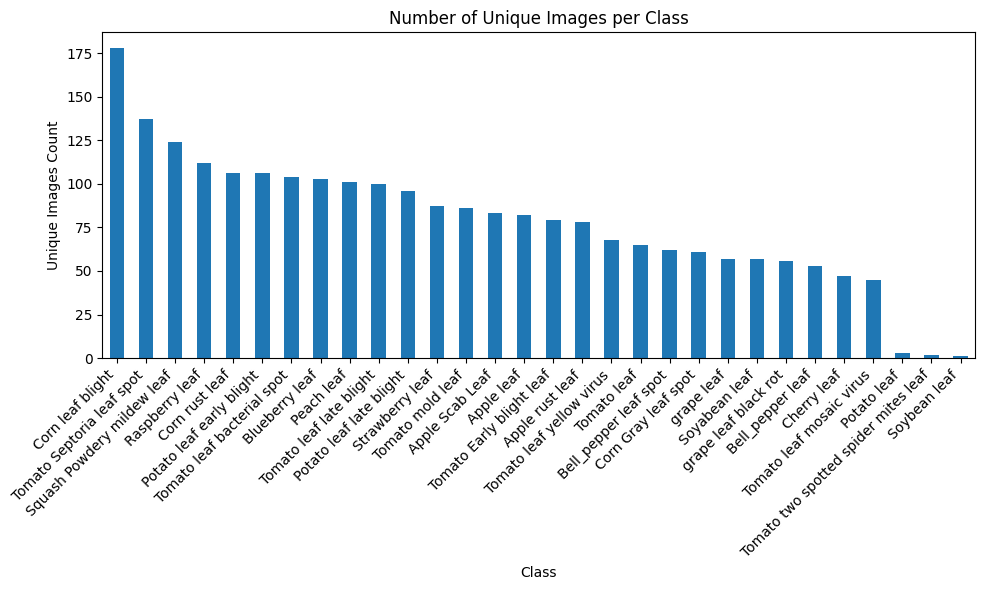

In [16]:
img_per_class = annotation.groupby("class")["filename"].nunique()

print(img_per_class)

# Optional: plot it
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
img_per_class.sort_values(ascending=False).plot(kind='bar')
plt.title("Number of Unique Images per Class")
plt.xlabel("Class")
plt.ylabel("Unique Images Count")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


In [17]:
annotation['class'] = annotation['class'].replace('Soybean leaf', 'Soyabean leaf')
print("Changed 'Soybean leaf' to 'Soyabean leaf'")

Changed 'Soybean leaf' to 'Soyabean leaf'


class
Blueberry leaf                          816
Tomato leaf yellow virus                759
Peach leaf                              579
Raspberry leaf                          539
Strawberry leaf                         443
Tomato Septoria leaf spot               402
Tomato leaf                             373
Corn leaf blight                        356
Bell_pepper leaf                        312
Potato leaf early blight                301
Tomato mold leaf                        279
Tomato leaf bacterial spot              266
Soyabean leaf                           261
Bell_pepper leaf spot                   248
Squash Powdery mildew leaf              248
Apple leaf                              237
Potato leaf late blight                 235
Tomato leaf mosaic virus                225
Cherry leaf                             220
grape leaf                              205
Tomato leaf late blight                 204
Tomato Early blight leaf                193
Apple rust leaf           

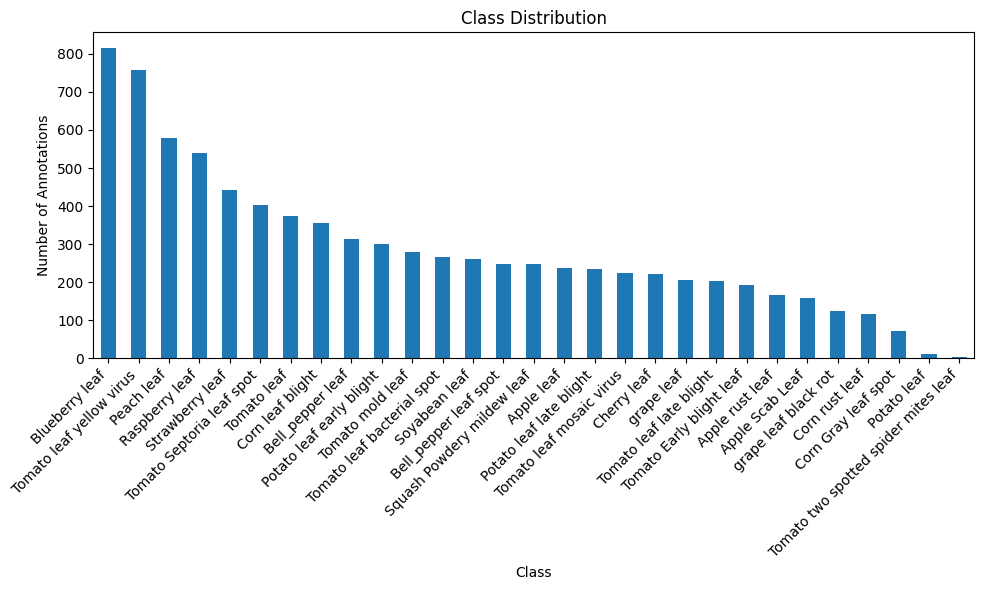

In [18]:
# Count number of samples per class
class_counts = annotation['class'].value_counts()

# Display counts
print(class_counts)

# Plot distribution
plt.figure(figsize=(10, 6))
class_counts.plot(kind='bar')
plt.title("Class Distribution")
plt.xlabel("Class")
plt.ylabel("Number of Annotations")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [19]:
num_classes = annotation['class'].nunique()
print(f"Number of unique classes: {num_classes}")

Number of unique classes: 29


In [20]:
cell_name = "SpotSpeckBlightMite-1l4v879_jpg.rf.e5e1f97a7071fa00e99d282befc837d3.jpg"
annotation.loc[
    (annotation["filename"] == cell_name) &
    (annotation["class"] == "Tomato two spotted spider mites leaf"),
    "class"
] = "Tomato Early blight leaf"

print(f"Updated class for filename: {cell_name}")

Updated class for filename: SpotSpeckBlightMite-1l4v879_jpg.rf.e5e1f97a7071fa00e99d282befc837d3.jpg


class
Apple Scab Leaf                          83
Apple leaf                               82
Apple rust leaf                          78
Bell_pepper leaf                         53
Bell_pepper leaf spot                    62
Blueberry leaf                          103
Cherry leaf                              47
Corn Gray leaf spot                      61
Corn leaf blight                        178
Corn rust leaf                          106
Peach leaf                              101
Potato leaf                               3
Potato leaf early blight                106
Potato leaf late blight                  96
Raspberry leaf                          112
Soyabean leaf                            58
Squash Powdery mildew leaf              124
Strawberry leaf                          87
Tomato Early blight leaf                 79
Tomato Septoria leaf spot               137
Tomato leaf                              65
Tomato leaf bacterial spot              104
Tomato leaf late blight   

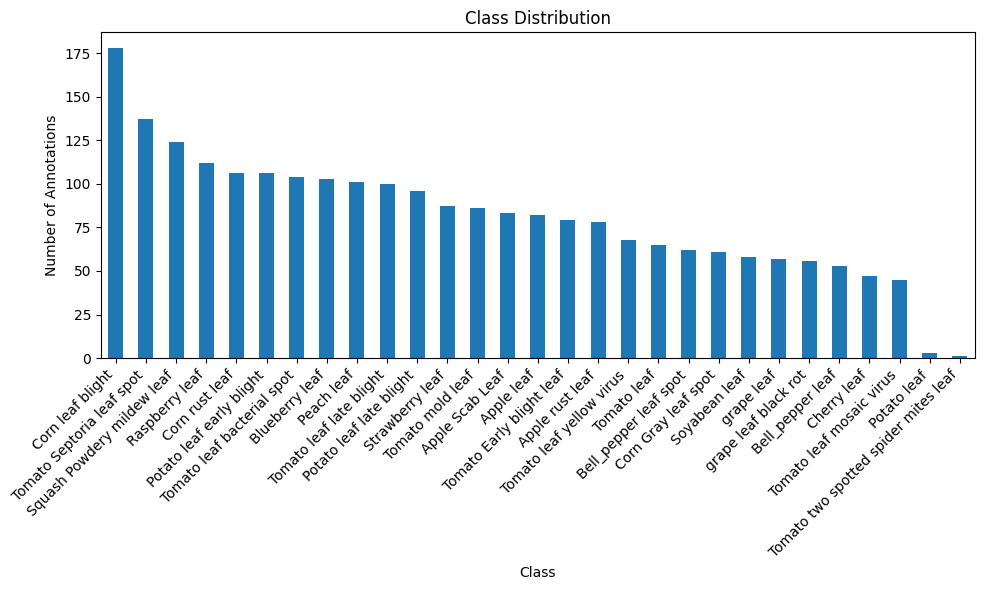

In [21]:
class_counts = annotation.groupby("class")["filename"].nunique()

# Display counts
print(class_counts)

# Plot distribution
plt.figure(figsize=(10, 6))
class_counts.sort_values(ascending=False).plot(kind='bar')
plt.title("Class Distribution")
plt.xlabel("Class")
plt.ylabel("Number of Annotations")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

class
Blueberry leaf                          816
Tomato leaf yellow virus                759
Peach leaf                              579
Raspberry leaf                          539
Strawberry leaf                         443
Tomato Septoria leaf spot               402
Tomato leaf                             373
Corn leaf blight                        356
Bell_pepper leaf                        312
Potato leaf early blight                301
Tomato mold leaf                        279
Tomato leaf bacterial spot              266
Soyabean leaf                           261
Bell_pepper leaf spot                   248
Squash Powdery mildew leaf              248
Apple leaf                              237
Potato leaf late blight                 235
Tomato leaf mosaic virus                225
Cherry leaf                             220
grape leaf                              205
Tomato leaf late blight                 204
Tomato Early blight leaf                194
Apple rust leaf           

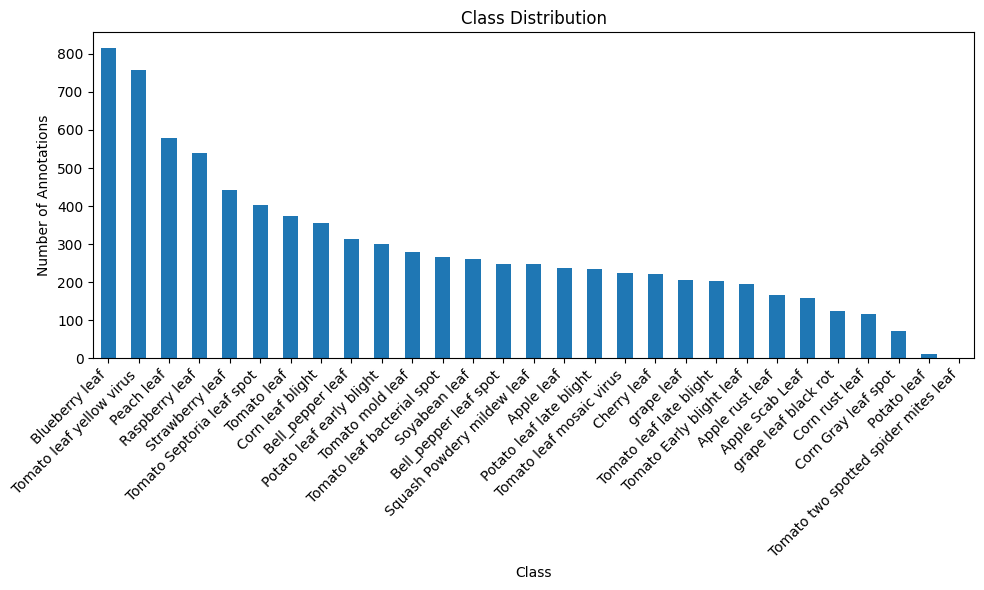

In [22]:
# Count number of samples per class
class_counts = annotation['class'].value_counts()

# Display counts
print(class_counts)

# Plot distribution
plt.figure(figsize=(10, 6))
class_counts.plot(kind='bar')
plt.title("Class Distribution")
plt.xlabel("Class")
plt.ylabel("Number of Annotations")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


**Test folder checking**

In [23]:
annotation_test = '/content/test/_annotations.csv'

In [24]:
problematic_lines = []
expected_cols = 8

with open(annotation_test, 'r') as f:
    reader = csv.reader(f)
    # Skip the header row
    header = next(reader)
    for i, row in enumerate(reader):
        if len(row) != expected_cols:
            problematic_lines.append((i + 2, row))

if problematic_lines:
    with open('problematic_lines.csv', 'w', newline='') as outfile:
        writer = csv.writer(outfile)
        writer.writerow(['Line Number', 'Problematic Row Content'])
        for line_num, row_content in problematic_lines:
            writer.writerow([line_num, ','.join(row_content)])

    print(f"Found {len(problematic_lines)} problematic lines. Details saved to 'problematic_lines.csv'.")
    print("Please review 'problematic_lines.csv' and fix the data in the original file.")
else:
    print("No problematic lines found in the annotation file.")

Found 2 problematic lines. Details saved to 'problematic_lines.csv'.
Please review 'problematic_lines.csv' and fix the data in the original file.


In [25]:
ANNOTATIONS = Path(annotation_test)
ENCODING    = "utf-8-sig"
OUT_CLEAN   = ANNOTATIONS.with_name(ANNOTATIONS.stem + "_clean.csv")
OUT_BAD     = ANNOTATIONS.with_name(ANNOTATIONS.stem + "_unfixable.csv")
EXPECTED_HEADER = ["filename","width","height","class","xmin","ymin","xmax","ymax"]


def is_int_token(s: str) -> bool:
    s = s.strip()
    if s.startswith(("+","-")): s = s[1:]
    return s.isdigit()

def first_consecutive_int_pair(tokens):
    """return index i where tokens[i] and tokens[i+1] are both ints; else None"""
    for i in range(len(tokens) - 1):
        if is_int_token(tokens[i]) and is_int_token(tokens[i+1]):
            return i
    return None

def rebuild_row(tokens):
    """
    tokens: list obtained by naive comma split via csv.reader
    returns (ok, row_or_reason)
    row format: [filename,width,height,class,xmin,ymin,xmax,ymax]
    """
    toks = [t.strip() for t in tokens if t is not None]

    # 1) locate width,height as the first consecutive int pair
    w_idx = first_consecutive_int_pair(toks)
    if w_idx is None:
        return False, "no consecutive width,height integers found"

    filename = ",".join(toks[:w_idx]).strip().strip('"')
    width, height = toks[w_idx], toks[w_idx + 1]
    rest = toks[w_idx + 2:]

    # Need at least 5 tokens after height (some class + 4 bbox ints)
    if len(rest) < 5:
        return False, "not enough fields after height"

    # 2) pick the LAST 4 integer tokens in 'rest' -> bbox
    bbox_indices = []
    for j in range(len(rest) - 1, -1, -1):
        if is_int_token(rest[j]):
            bbox_indices.append(j)
            if len(bbox_indices) == 4:
                break
    if len(bbox_indices) != 4:
        return False, "could not find 4 bbox integers in tail"
    bbox_indices.sort()
    xmin, ymin, xmax, ymax = [rest[k] for k in bbox_indices]

    # 3) class = everything between height and earliest bbox int
    class_tokens = rest[:bbox_indices[0]]
    if not class_tokens:
        return False, "class field missing"
    class_name = ",".join(class_tokens).strip().strip('"')

    return True, [filename, width, height, class_name, xmin, ymin, xmax, ymax]

def main():
    fixed, bad = [], []

    with ANNOTATIONS.open(encoding=ENCODING, newline="") as f:
        rdr = csv.reader(f)
        _ = next(rdr, None)  # skip original header if present
        for row in rdr:
            ok, out = rebuild_row(row)
            if ok:
                fixed.append(out)
            else:
                bad.append({"reason": out, "raw": ",".join(row)})

    # Write clean file
    with OUT_CLEAN.open("w", newline="", encoding=ENCODING) as f:
        w = csv.writer(f)
        w.writerow(EXPECTED_HEADER)
        w.writerows(fixed)

    # Write any unfixable rows for manual check
    with OUT_BAD.open("w", newline="", encoding=ENCODING) as f:
        w = csv.writer(f)
        w.writerow(["reason","raw_line"])
        for br in bad:
            w.writerow([br["reason"], br["raw"]])

    print(f" Clean rows written: {len(fixed)} -> {OUT_CLEAN}")
    print(f" Unfixable empty rows: {len(bad)} -> {OUT_BAD}")

if __name__ == "__main__":
    main()

 Clean rows written: 454 -> /content/test/_annotations_clean.csv
 Unfixable empty rows: 1 -> /content/test/_annotations_unfixable.csv


In [26]:
annotation_test_clean = pd.read_csv('/content/test/_annotations_clean.csv')

In [27]:
annotation_test_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 454 entries, 0 to 453
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   filename  454 non-null    object
 1   width     454 non-null    int64 
 2   height    454 non-null    int64 
 3   class     454 non-null    object
 4   xmin      454 non-null    int64 
 5   ymin      454 non-null    int64 
 6   xmax      454 non-null    int64 
 7   ymax      454 non-null    int64 
dtypes: int64(6), object(2)
memory usage: 28.5+ KB


In [28]:
base_dir = Path("/content/test")

missing_files = [
    f for f in annotation_test_clean["filename"].unique()
    if not (base_dir / f).exists()
]

if missing_files:
    pd.Series(missing_files, name="filename").to_csv("missing_images.csv", index=False)
    print(f"⚠ Found {len(missing_files)} missing files. Saved to missing_images.csv")
else:
    print(" All files exist. No action needed.")


 All files exist. No action needed.


In [29]:
duplicate_rows = annotation_test_clean.duplicated().sum()
print(f"Number of duplicate rows: {duplicate_rows}")

Number of duplicate rows: 0


In [30]:
num_classes = annotation_test_clean['class'].nunique()
print(f"Number of classes: {num_classes}")

Number of classes: 27


class
Apple Scab Leaf               10
Apple leaf                     9
Apple rust leaf               10
Bell_pepper leaf               8
Bell_pepper leaf spot          9
Blueberry leaf                11
Cherry leaf                   10
Corn Gray leaf spot            4
Corn leaf blight              12
Corn rust leaf                10
Peach leaf                     9
Potato leaf early blight       8
Potato leaf late blight        8
Raspberry leaf                 7
Soyabean leaf                  8
Squash Powdery mildew leaf     8
Strawberry leaf                8
Tomato Early blight leaf       9
Tomato Septoria leaf spot     11
Tomato leaf                    8
Tomato leaf bacterial spot     9
Tomato leaf late blight       10
Tomato leaf mosaic virus      10
Tomato leaf yellow virus       6
Tomato mold leaf               6
grape leaf                    12
grape leaf black rot           8
Name: filename, dtype: int64


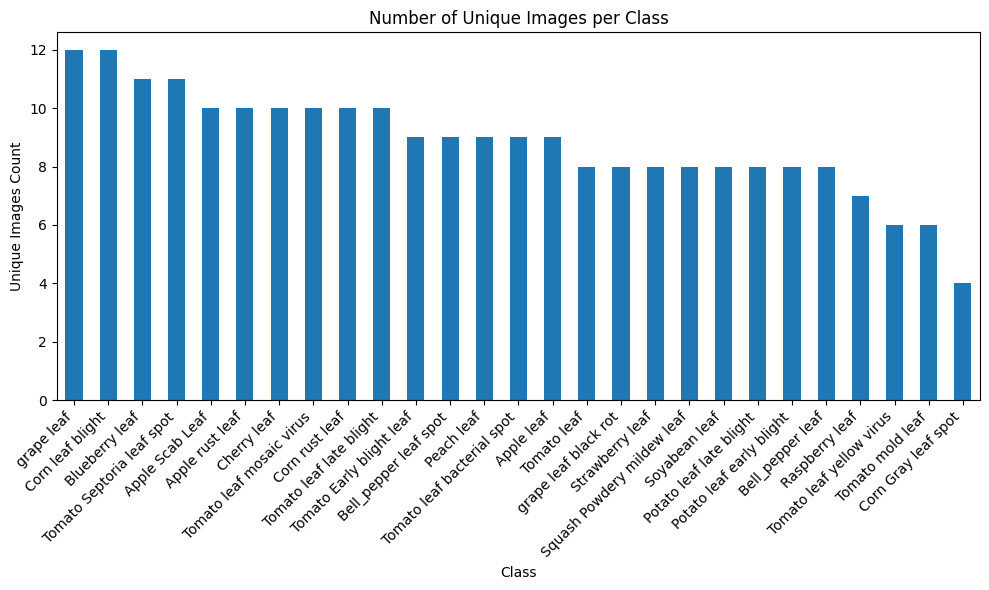

In [31]:
img_per_class = annotation_test_clean.groupby("class")["filename"].nunique()

print(img_per_class)

# Optional: plot it
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
img_per_class.sort_values(ascending=False).plot(kind='bar')
plt.title("Number of Unique Images per Class")
plt.xlabel("Class")
plt.ylabel("Unique Images Count")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


class
Tomato leaf yellow virus      42
Tomato leaf mosaic virus      36
Strawberry leaf               30
Tomato leaf                   27
Tomato Septoria leaf spot     24
Blueberry leaf                22
Soyabean leaf                 20
Cherry leaf                   19
Tomato Early blight leaf      19
Raspberry leaf                17
Potato leaf early blight      17
Tomato mold leaf              16
grape leaf                    15
Bell_pepper leaf spot         15
Tomato leaf bacterial spot    14
Tomato leaf late blight       14
Apple Scab Leaf               13
Corn leaf blight              12
Bell_pepper leaf              11
Apple rust leaf               11
Peach leaf                    10
Corn rust leaf                10
Potato leaf late blight       10
Apple leaf                    10
Squash Powdery mildew leaf     8
grape leaf black rot           8
Corn Gray leaf spot            4
Name: count, dtype: int64


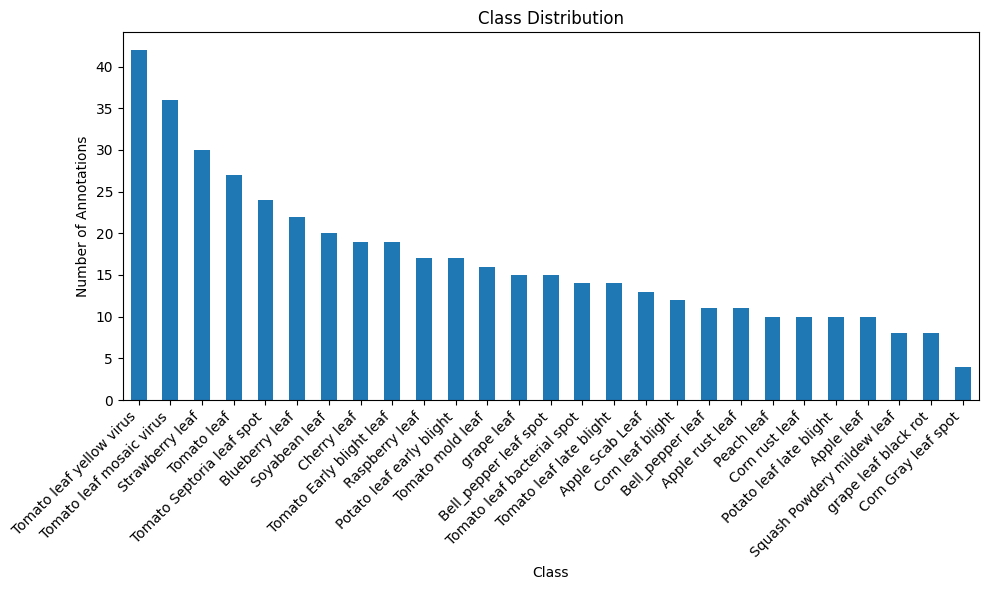

In [32]:
# Count number of samples per class
class_counts = annotation_test_clean['class'].value_counts()

# Display counts
print(class_counts)

# Plot distribution
plt.figure(figsize=(10, 6))
class_counts.plot(kind='bar')
plt.title("Class Distribution")
plt.xlabel("Class")
plt.ylabel("Number of Annotations")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [33]:
#finding same filenames in both test and train dataset
common_filenames = set(annotation['filename']).intersection(set(annotation_test_clean['filename']))

if common_filenames:
    print(f"Found {len(common_filenames)} common filenames:")
    for filename in list(common_filenames):
        print(filename)
else:
    print("No common filenames found in annotation and annotation_test_clean.")

No common filenames found in annotation and annotation_test_clean.


# **Data Preprocessing**

In [34]:
annotation = annotation[~annotation['class'].isin(['Tomato two spotted spider mites leaf', 'Potato leaf'])]

class
Apple Scab Leaf                83
Apple leaf                     82
Apple rust leaf                78
Bell_pepper leaf               53
Bell_pepper leaf spot          62
Blueberry leaf                103
Cherry leaf                    47
Corn Gray leaf spot            61
Corn leaf blight              178
Corn rust leaf                106
Peach leaf                    101
Potato leaf early blight      106
Potato leaf late blight        96
Raspberry leaf                112
Soyabean leaf                  58
Squash Powdery mildew leaf    124
Strawberry leaf                87
Tomato Early blight leaf       79
Tomato Septoria leaf spot     137
Tomato leaf                    65
Tomato leaf bacterial spot    104
Tomato leaf late blight       100
Tomato leaf mosaic virus       45
Tomato leaf yellow virus       68
Tomato mold leaf               86
grape leaf                     57
grape leaf black rot           56
Name: filename, dtype: int64


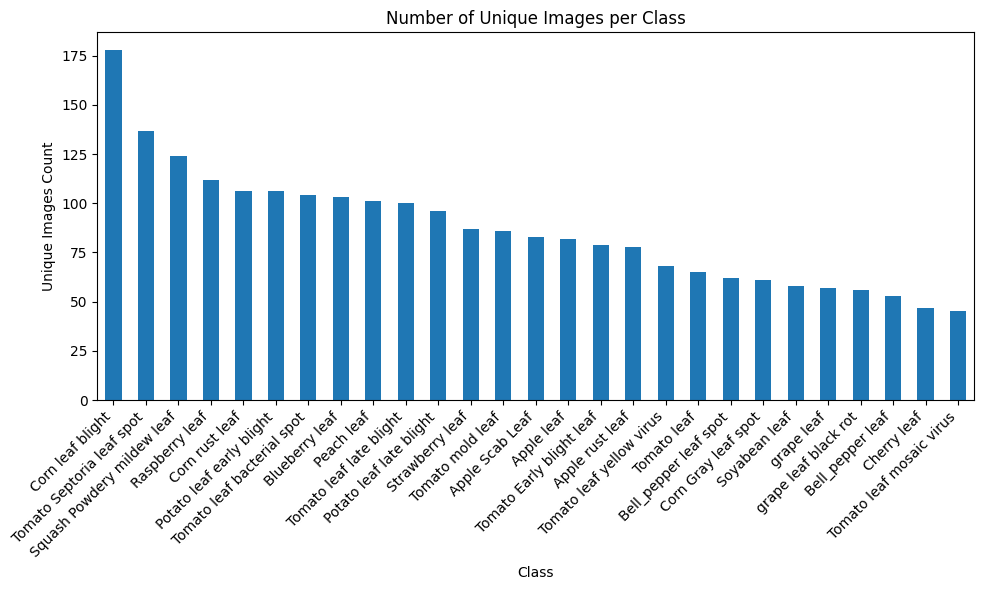

In [35]:
img_per_class = annotation.groupby("class")["filename"].nunique()

print(img_per_class)

# Optional: plot it
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
img_per_class.sort_values(ascending=False).plot(kind='bar')
plt.title("Number of Unique Images per Class")
plt.xlabel("Class")
plt.ylabel("Unique Images Count")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


In [36]:
import os
import shutil

source_dir = '/content/train'
destination_dir = '/content/train/images'

# Create the destination directory if it doesn't exist
os.makedirs(destination_dir, exist_ok=True)

# List all files in the source directory
all_files = os.listdir(source_dir)

moved_count = 0
for filename in all_files:
    source_path = os.path.join(source_dir, filename)
    destination_path = os.path.join(destination_dir, filename)

    # Check if the file is a file (not a directory) and if it has a .jpg extension
    if os.path.isfile(source_path) and filename.lower().endswith('.jpg'):
        try:
            shutil.move(source_path, destination_path)
            moved_count += 1
        except Exception as e:
            print(f"Error moving {filename}: {e}")

print(f"Moved {moved_count} image files from {source_dir} to {destination_dir}")

Moved 2328 image files from /content/train to /content/train/images


In [37]:
import os
import shutil

source_dir = '/content/test'
destination_dir = '/content/test/images'

# Create the destination directory if it doesn't exist
os.makedirs(destination_dir, exist_ok=True)

# List all files in the source directory
all_files = os.listdir(source_dir)

moved_count = 0
for filename in all_files:
    source_path = os.path.join(source_dir, filename)
    destination_path = os.path.join(destination_dir, filename)

    # Check if the file is a file (not a directory) and if it has a .jpg extension
    if os.path.isfile(source_path) and filename.lower().endswith('.jpg'):
        try:
            shutil.move(source_path, destination_path)
            moved_count += 1
        except Exception as e:
            print(f"Error moving {filename}: {e}")

print(f"Moved {moved_count} image files from {source_dir} to {destination_dir}")

Moved 239 image files from /content/test to /content/test/images


In [38]:
import pandas as pd
from sklearn.model_selection import train_test_split
from pathlib import Path

df = annotation

# One row per image: pick a representative class per image (most frequent class)
per_image = (
    df.groupby('filename')['class']
      .agg(lambda s: s.mode().iat[0])  # if multiple modes, take the first
      .reset_index()
)

# Split image names into train/val (shuffles by default; set random_state for reproducibility)
train_names, val_names = train_test_split(
    per_image['filename'],
    test_size=0.1,         # 20% goes to validation
    shuffle=True,          # default is True; included here for clarity
    random_state=42,       # make the split repeatable
    stratify=per_image['class']  # keep class distribution balanced
)

# Filter the original CSV rows by image names → full per-image annotations
train_df = df[df['filename'].isin(train_names)]
val_df   = df[df['filename'].isin(val_names)]


SAVE_train = Path("/content/train")
SAVE_train.mkdir(parents=True, exist_ok=True)

SAVE_val = Path("/content/validation")
SAVE_val.mkdir(parents=True, exist_ok=True)



# Save split CSVs
train_df.to_csv(SAVE_train / "train_annotations.csv", index=False)
val_df.to_csv(SAVE_val / "val_annotations.csv", index=False)

print(f"Saved {len(train_df)} rows to {SAVE_train / 'train_annotations.csv'}")
print(f"Saved {len(val_df)} rows to {SAVE_val / 'val_annotations.csv'}")

Saved 7508 rows to /content/train/train_annotations.csv
Saved 833 rows to /content/validation/val_annotations.csv


In [39]:
import os
import shutil

# Define the base directory for the training images
base_dir = '/content/train/images'

# Define the directory for the validation images
val_dir = '/content/validation/images'
os.makedirs(val_dir, exist_ok=True)

# Move validation images to the validation directory
moved_count = 0
for filename in val_df['filename'].unique():
    src_path = os.path.join(base_dir, filename)
    dest_path = os.path.join(val_dir, filename)
    if os.path.exists(src_path):
        shutil.move(src_path, dest_path)
        moved_count += 1
    else:
        print(f"Warning: File not found in training directory: {src_path}")

print(f"\nAttempted to move {len(val_df['filename'].unique())} unique validation images. Successfully moved {moved_count} images to {val_dir}.")


Attempted to move 232 unique validation images. Successfully moved 232 images to /content/validation/images.


In [40]:
import pandas as pd
from pathlib import Path
from urllib.parse import unquote
import re

def convert_csv_to_yolo(CSV_PATH, OUT_DIR):
  # -------- Paths (edit these) --------
  CSV_PATH = CSV_PATH           # your CSV file
  OUT_DIR  = OUT_DIR # output folder for YOLO label .txt files

  # -------- Exact class order (IDs 0..26) --------
  CLASSES = [
      'Apple Scab Leaf','Apple leaf','Apple rust leaf','Bell_pepper leaf','Bell_pepper leaf spot',
      'Blueberry leaf','Cherry leaf','Corn Gray leaf spot','Corn leaf blight','Corn rust leaf',
      'Peach leaf','Potato leaf early blight','Potato leaf late blight','Raspberry leaf','Soyabean leaf',
      'Squash Powdery mildew leaf','Strawberry leaf','Tomato Early blight leaf','Tomato Septoria leaf spot',
      'Tomato leaf','Tomato leaf bacterial spot','Tomato leaf late blight','Tomato leaf mosaic virus',
      'Tomato leaf yellow virus','Tomato mold leaf','grape leaf','grape leaf black rot'
  ]
  assert len(CLASSES) == 27, "CLASSES must contain exactly 27 names."

  # Normalize class names for robust matching (spaces/underscores/case-insensitive)
  def norm(s: str) -> str:
      s = unquote(str(s)).strip()
      s = s.replace("_", " ")
      s = re.sub(r"\s+", " ", s)
      return s.lower()

  name2id = {norm(name): i for i, name in enumerate(CLASSES)}

  # -------- Read CSV --------
  df = pd.read_csv(CSV_PATH)
  df.columns = [str(c).strip().lower() for c in df.columns]

  required = ["filename","width","height","class","xmin","ymin","xmax","ymax"]
  missing = [c for c in required if c not in df.columns]
  if missing:
      raise ValueError(f"Missing required CSV columns: {missing}")

  # Keep only the filename (drop folders) and build the stem (basename without extension)
  df["__file"] = df["filename"].map(lambda x: Path(unquote(str(x))).name)
  df["__stem"] = df["__file"].map(lambda x: Path(x).stem)

  # Ensure every class in CSV exists in your CLASSES list
  unknown = sorted(set(norm(x) for x in df["class"]) - set(name2id.keys()))
  if unknown:
      raise ValueError(
          "Some CSV classes are not in your CLASSES list (so IDs cannot match your order):\n"
          + "\n".join(unknown)
      )

  # Convert one row to a YOLO line: "<class_id> <cx> <cy> <w> <h>" (all normalized to [0,1])
  def row_to_line(r):
      W, H = float(r["width"]), float(r["height"])
      xmin, ymin, xmax, ymax = float(r["xmin"]), float(r["ymin"]), float(r["xmax"]), float(r["ymax"])

      # Standard YOLO conversion from XYXY (top-left / bottom-right in pixels)
      cx = ((xmin + xmax) / 2.0) / W
      cy = ((ymin + ymax) / 2.0) / H
      w  = (xmax - xmin) / W
      h  = (ymax - ymin) / H

      # Clamp to [0,1] just in case
      clip = lambda v: max(0.0, min(1.0, float(v)))
      cx, cy, w, h = map(clip, (cx, cy, w, h))

      cls_id = name2id[norm(r["class"])]
      return f"{cls_id} {cx:.6f} {cy:.6f} {w:.6f} {h:.6f}"

  # -------- Write one .txt per image (same basename) --------
  out = Path(OUT_DIR)
  out.mkdir(parents=True, exist_ok=True)

  files_written = 0
  boxes_total = 0
  for stem, g in df.groupby("__stem"):
      lines = [row_to_line(r) for _, r in g.iterrows()]
      (out / f"{stem}.txt").write_text("\n".join(lines), encoding="utf-8")
      files_written += 1
      boxes_total += len(lines)

  # Optional: save the classes list (ID order) for reference
  (out / "classes.txt").write_text("\n".join(CLASSES), encoding="utf-8")

  print(f"✅ Done: wrote {files_written} label files with {boxes_total} boxes into: {out}")
  print("Class ID mapping (id → name):")
  for i, name in enumerate(CLASSES):
      print(f"{i:2d}: {name}")


**Train converting csv to txt**

In [41]:
convert_csv_to_yolo("/content/train/train_annotations.csv", "/content/train/labels")

✅ Done: wrote 2086 label files with 7508 boxes into: /content/train/labels
Class ID mapping (id → name):
 0: Apple Scab Leaf
 1: Apple leaf
 2: Apple rust leaf
 3: Bell_pepper leaf
 4: Bell_pepper leaf spot
 5: Blueberry leaf
 6: Cherry leaf
 7: Corn Gray leaf spot
 8: Corn leaf blight
 9: Corn rust leaf
10: Peach leaf
11: Potato leaf early blight
12: Potato leaf late blight
13: Raspberry leaf
14: Soyabean leaf
15: Squash Powdery mildew leaf
16: Strawberry leaf
17: Tomato Early blight leaf
18: Tomato Septoria leaf spot
19: Tomato leaf
20: Tomato leaf bacterial spot
21: Tomato leaf late blight
22: Tomato leaf mosaic virus
23: Tomato leaf yellow virus
24: Tomato mold leaf
25: grape leaf
26: grape leaf black rot


**Validation converting csv to txt**

In [42]:
convert_csv_to_yolo("/content/validation/val_annotations.csv", "/content/validation/labels")

✅ Done: wrote 232 label files with 833 boxes into: /content/validation/labels
Class ID mapping (id → name):
 0: Apple Scab Leaf
 1: Apple leaf
 2: Apple rust leaf
 3: Bell_pepper leaf
 4: Bell_pepper leaf spot
 5: Blueberry leaf
 6: Cherry leaf
 7: Corn Gray leaf spot
 8: Corn leaf blight
 9: Corn rust leaf
10: Peach leaf
11: Potato leaf early blight
12: Potato leaf late blight
13: Raspberry leaf
14: Soyabean leaf
15: Squash Powdery mildew leaf
16: Strawberry leaf
17: Tomato Early blight leaf
18: Tomato Septoria leaf spot
19: Tomato leaf
20: Tomato leaf bacterial spot
21: Tomato leaf late blight
22: Tomato leaf mosaic virus
23: Tomato leaf yellow virus
24: Tomato mold leaf
25: grape leaf
26: grape leaf black rot


**Test converting csv to txt**

In [43]:
convert_csv_to_yolo("/content/test/_annotations_clean.csv", "/content/test/labels")

✅ Done: wrote 238 label files with 454 boxes into: /content/test/labels
Class ID mapping (id → name):
 0: Apple Scab Leaf
 1: Apple leaf
 2: Apple rust leaf
 3: Bell_pepper leaf
 4: Bell_pepper leaf spot
 5: Blueberry leaf
 6: Cherry leaf
 7: Corn Gray leaf spot
 8: Corn leaf blight
 9: Corn rust leaf
10: Peach leaf
11: Potato leaf early blight
12: Potato leaf late blight
13: Raspberry leaf
14: Soyabean leaf
15: Squash Powdery mildew leaf
16: Strawberry leaf
17: Tomato Early blight leaf
18: Tomato Septoria leaf spot
19: Tomato leaf
20: Tomato leaf bacterial spot
21: Tomato leaf late blight
22: Tomato leaf mosaic virus
23: Tomato leaf yellow virus
24: Tomato mold leaf
25: grape leaf
26: grape leaf black rot


In [44]:
import yaml

# Define the paths to your training and validation data
train_img_dir = '/content/train/images'
train_label_dir = '/content/train/labels'
val_img_dir = '/content/validation/images'
val_label_dir = '/content/validation/labels'
test_img_dir = '/content/test/images'
test_label_dir = '/content/test/labels'


# Define the class names in the order they appear in your labels
classes = [
    'Apple Scab Leaf','Apple leaf','Apple rust leaf','Bell_pepper leaf','Bell_pepper leaf spot',
    'Blueberry leaf','Cherry leaf','Corn Gray leaf spot','Corn leaf blight','Corn rust leaf',
    'Peach leaf','Potato leaf early blight','Potato leaf late blight','Raspberry leaf','Soyabean leaf',
    'Squash Powdery mildew leaf','Strawberry leaf','Tomato Early blight leaf','Tomato Septoria leaf spot',
    'Tomato leaf','Tomato leaf bacterial spot','Tomato leaf late blight','Tomato leaf mosaic virus',
    'Tomato leaf yellow virus','Tomato mold leaf','grape leaf','grape leaf black rot'
]



# Create the data dictionary
data = {
    'train': train_img_dir,
    'val': val_img_dir,
    'test': test_img_dir,
    'nc': len(classes),
    'names': classes,
}

# Define the path to save the data.yaml file
data_yaml_path = '/content/data.yaml'

# Write the data dictionary to the data.yaml file
with open(data_yaml_path, 'w') as f:
    yaml.dump(data, f)

print(f"data.yaml file created at: {data_yaml_path}")

data.yaml file created at: /content/data.yaml


In [46]:
from pathlib import Path
from collections import Counter

LBL_DIR = Path("/content/train/labels")
areas = []
per_class = {}

for p in LBL_DIR.rglob("*.txt"):
    for ln in p.read_text().splitlines():
        sp = ln.split()
        if len(sp) < 5:
            continue
        c = int(sp[0]); x,y,w,h = map(float, sp[1:5])
        a = w*h
        areas.append(a)
        per_class.setdefault(c, []).append(a)

bins = {"tiny":0,"small":0,"medium":0,"large":0}
for a in areas:
    if a < 0.005: bins["tiny"]+=1
    elif a < 0.02: bins["small"]+=1
    elif a < 0.15: bins["medium"]+=1
    else: bins["large"]+=1

tot = max(1,len(areas))
print(f"Total instances: {tot}")
for k,v in bins.items():
    print(f"{k}: {v}  ({100*v/tot:.1f}%)")

import statistics as st
print("\nPer-class median area (instance):")
for c, arr in list(per_class.items())[:10]:
    print(f"class {c}: median={st.median(arr):.4f}")


ValueError: invalid literal for int() with base 10: '22.0'

**Augmentation**

In [ ]:
'''import albumentations as A

transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.Affine(scale=(0.9, 1.1), translate_percent=(0.05, 0.05),
             rotate=10, shear=0, cval=114, p=0.7),     # هندسی ملایم
    A.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.02, p=0.4),
    A.GaussianBlur(blur_limit=(3,5), p=0.1),           # تاری خیلی کم
], bbox_params=A.BboxParams(
    format="yolo",              # x_c y_c w h (همه 0..1)
    label_fields=["class_labels"],
    min_visibility=0.30
))
'''

# **Modeling**

In [ ]:
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 34.8 MB/s eta 0:00:00


In [ ]:
from ultralytics import YOLO

# Load a COCO-pretrained YOLO12n model
model = YOLO("yolo12n.pt")

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [ ]:
import torch
print("CUDA available:", torch.cuda.is_available())
print("GPU name:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "None")


CUDA available: True
GPU name: Tesla T4


In [ ]:
model.train(
    data='/content/data.yaml',
    epochs=100,
    imgsz=640,
    batch=16,         # auto
    optimizer='Adam',
    device=0 # or 'SGD', 'Adam', etc.
)

Ultralytics 8.3.182 🚀 Python-3.12.11 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=100, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo12n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train, nbs=64, nms=False, opset=None, optimize=False, optimizer=Adam, overlap_mask=True, patience=100, perspective=0.0, plots=True, pose=12.0, pretrained=True, profi

Overriding model.yaml nc=80 with nc=27

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      6640  ultralytics.nn.modules.block.C3k2            [32, 64, 1, False, 0.25]      
  3                  -1  1     36992  ultralytics.nn.modules.conv.Conv             [64, 64, 3, 2]                
  4                  -1  1     26080  ultralytics.nn.modules.block.C3k2            [64, 128, 1, False, 0.25]     
  5                  -1  1    147712  ultralytics.nn.modules.conv.Conv             [128, 128, 3, 2]              
  6                  -1  2    180864  ultralytics.nn.modules.block.A2C2f           [128, 128, 2, True, 4]        
  7                  -1  1    295424  ultralytic

 20                  -1  1    378880  ultralytics.nn.modules.block.C3k2            [384, 256, 1, True]           
 21        [14, 17, 20]  1    435937  ultralytics.nn.modules.head.Detect           [27, [64, 128, 256]]          
YOLOv12n summary: 272 layers, 2,573,313 parameters, 2,573,297 gradients, 6.5 GFLOPs

Transferred 640/691 items from pretrained weights
Freezing layer 'model.21.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks...


AMP: checks passed ✅
train: Fast image access ✅ (ping: 0.0±0.0 ms, read: 897.9±481.5 MB/s, size: 30.1 KB)


train: Scanning /content/train/labels... 1948 images, 148 backgrounds, 0 corrupt: 100%|██████████| 2096/2096 [00:01<00:00, 2009.99it/s]

train: New cache created: /content/train/labels.cache


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 375.0±133.9 MB/s, size: 26.8 KB)


val: Scanning /content/validation/labels... 218 images, 14 backgrounds, 0 corrupt: 100%|██████████| 232/232 [00:00<00:00, 920.40it/s]

val: New cache created: /content/validation/labels.cache


Plotting labels to runs/detect/train/labels.jpg... 
optimizer: Adam(lr=0.01, momentum=0.937) with parameter groups 113 weight(decay=0.0), 120 weight(decay=0.0005), 119 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/train
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100      3.34G      1.758      4.035      1.863         98        640: 100%|██████████| 131/131 [00:57<00:00,  2.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:14<00:00,  1.79s/it]

                   all        232        788      0.409     0.0526    0.00209   0.000624



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100      3.74G      1.821      3.808      1.969        113        640: 100%|██████████| 131/131 [00:44<00:00,  2.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.03it/s]


                   all        232        788      0.649      0.031    0.00458    0.00187

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100      3.75G      1.816      3.755      1.938         86        640: 100%|██████████| 131/131 [00:44<00:00,  2.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.63it/s]


                   all        232        788      0.166      0.135     0.0107    0.00524

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100      3.77G       1.76      3.657      1.933         85        640: 100%|██████████| 131/131 [00:43<00:00,  3.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.67it/s]

                   all        232        788       0.56     0.0156    0.00207   0.000973



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100      3.78G      1.724      3.601      1.882         96        640: 100%|██████████| 131/131 [00:42<00:00,  3.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.23it/s]


                   all        232        788      0.308       0.12     0.0144    0.00645

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100       3.8G      1.684      3.531      1.844        122        640: 100%|██████████| 131/131 [00:43<00:00,  3.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  2.79it/s]


                   all        232        788      0.325      0.131     0.0422     0.0225

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100      3.81G      1.632      3.476       1.81         66        640: 100%|██████████| 131/131 [00:43<00:00,  3.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.41it/s]


                   all        232        788      0.543     0.0782     0.0309     0.0152

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100      3.83G      1.621      3.372      1.806         82        640: 100%|██████████| 131/131 [00:43<00:00,  2.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.05it/s]


                   all        232        788      0.469      0.132     0.0514      0.028

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100      3.84G      1.588      3.372      1.767         79        640: 100%|██████████| 131/131 [00:43<00:00,  3.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.69it/s]

                   all        232        788      0.438       0.16     0.0522     0.0284



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100      3.86G      1.596      3.319      1.765         93        640: 100%|██████████| 131/131 [00:44<00:00,  2.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.81it/s]

                   all        232        788      0.379      0.128     0.0565     0.0317



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100      3.87G      1.584      3.287      1.751         70        640: 100%|██████████| 131/131 [00:43<00:00,  3.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.85it/s]

                   all        232        788      0.384      0.135     0.0593     0.0338



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/100      3.88G      1.561      3.278      1.742        103        640: 100%|██████████| 131/131 [00:46<00:00,  2.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.79it/s]


                   all        232        788      0.481      0.157      0.078     0.0444

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/100       3.9G      1.559      3.269       1.75         89        640: 100%|██████████| 131/131 [00:45<00:00,  2.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.60it/s]


                   all        232        788      0.451      0.132     0.0608     0.0343

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/100      3.91G      1.578      3.227      1.763        126        640: 100%|██████████| 131/131 [00:45<00:00,  2.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.42it/s]


                   all        232        788      0.402      0.144     0.0679     0.0388

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/100      3.93G       1.55      3.197      1.731        140        640: 100%|██████████| 131/131 [00:47<00:00,  2.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.81it/s]

                   all        232        788      0.644      0.143     0.0929     0.0492



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/100      3.94G       1.52      3.143      1.691         98        640: 100%|██████████| 131/131 [00:44<00:00,  2.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  2.88it/s]

                   all        232        788       0.35      0.146     0.0868     0.0512



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/100      3.96G      1.509      3.124      1.695         53        640: 100%|██████████| 131/131 [00:43<00:00,  2.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.88it/s]

                   all        232        788      0.433      0.136     0.0708     0.0392



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/100      3.97G      1.521      3.146       1.71        116        640: 100%|██████████| 131/131 [00:44<00:00,  2.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.53it/s]


                   all        232        788      0.364      0.162     0.0853     0.0493

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/100      3.99G      1.514      3.107      1.679         96        640: 100%|██████████| 131/131 [00:43<00:00,  3.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.97it/s]

                   all        232        788      0.304      0.154     0.0741     0.0442



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/100         4G      1.509      3.099      1.696        102        640: 100%|██████████| 131/131 [00:44<00:00,  2.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.72it/s]


                   all        232        788       0.41      0.163     0.0773     0.0415

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/100      4.02G      1.512      3.053      1.687         65        640: 100%|██████████| 131/131 [00:42<00:00,  3.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.85it/s]

                   all        232        788      0.202       0.17     0.0914     0.0545



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/100      4.03G      1.494      3.057      1.688         97        640: 100%|██████████| 131/131 [00:44<00:00,  2.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.01it/s]


                   all        232        788      0.246      0.193     0.0904     0.0524

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/100      4.05G      1.487       3.05      1.669        107        640: 100%|██████████| 131/131 [00:43<00:00,  3.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.82it/s]


                   all        232        788      0.274      0.152     0.0659     0.0394

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/100      4.06G      1.473      3.021      1.655        123        640: 100%|██████████| 131/131 [00:44<00:00,  2.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.97it/s]

                   all        232        788      0.402      0.154     0.0883      0.053



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/100      4.08G      1.485      3.006      1.666         87        640: 100%|██████████| 131/131 [00:43<00:00,  2.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  2.96it/s]

                   all        232        788      0.252      0.179      0.101     0.0604



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/100      4.09G      1.484      3.013       1.68        148        640: 100%|██████████| 131/131 [00:43<00:00,  3.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.86it/s]

                   all        232        788      0.322      0.202      0.111     0.0626



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/100      4.11G      1.454      2.948      1.643         87        640: 100%|██████████| 131/131 [00:44<00:00,  2.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.12it/s]

                   all        232        788      0.326      0.194      0.101     0.0604



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/100      4.12G      1.478      2.961       1.67        132        640: 100%|██████████| 131/131 [00:43<00:00,  2.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.72it/s]


                   all        232        788      0.426      0.227     0.0989     0.0573

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/100      4.14G      1.465      2.933       1.66         97        640: 100%|██████████| 131/131 [00:44<00:00,  2.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.92it/s]

                   all        232        788      0.341      0.162      0.112     0.0658



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/100      4.15G      1.446      2.896      1.636         70        640: 100%|██████████| 131/131 [00:43<00:00,  3.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.97it/s]

                   all        232        788      0.236      0.165      0.112     0.0707



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/100      4.17G      1.454      2.907       1.64         83        640: 100%|██████████| 131/131 [00:45<00:00,  2.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.93it/s]

                   all        232        788      0.181      0.216      0.111     0.0674



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/100      4.18G      1.458      2.914      1.645         70        640: 100%|██████████| 131/131 [00:44<00:00,  2.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.68it/s]


                   all        232        788      0.222      0.231       0.12     0.0734

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/100       4.2G      1.431      2.863       1.63        105        640: 100%|██████████| 131/131 [00:44<00:00,  2.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.89it/s]


                   all        232        788      0.248      0.229      0.124      0.076

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/100      4.21G      1.449      2.863      1.647         94        640: 100%|██████████| 131/131 [00:42<00:00,  3.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  2.93it/s]

                   all        232        788      0.325      0.238      0.127     0.0748



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/100      4.23G       1.44      2.837      1.628         77        640: 100%|██████████| 131/131 [00:43<00:00,  3.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.92it/s]

                   all        232        788       0.24      0.208      0.117      0.071



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/100      4.24G      1.463      2.831      1.651        110        640: 100%|██████████| 131/131 [00:43<00:00,  3.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.04it/s]

                   all        232        788      0.179       0.25      0.149     0.0871



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/100      4.26G      1.434      2.805      1.626         81        640: 100%|██████████| 131/131 [00:43<00:00,  3.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.87it/s]

                   all        232        788      0.177      0.243      0.135     0.0828



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/100      4.27G       1.44      2.809      1.643         67        640: 100%|██████████| 131/131 [00:43<00:00,  2.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.62it/s]

                   all        232        788       0.27      0.211      0.126     0.0785



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/100      4.29G      1.445      2.792      1.632         88        640: 100%|██████████| 131/131 [00:42<00:00,  3.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.95it/s]

                   all        232        788      0.216      0.238      0.129     0.0788



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/100       4.3G      1.416      2.764       1.62        101        640: 100%|██████████| 131/131 [00:44<00:00,  2.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.82it/s]

                   all        232        788      0.242      0.245      0.139     0.0874



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/100      4.31G      1.412      2.735      1.613         92        640: 100%|██████████| 131/131 [00:42<00:00,  3.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.86it/s]

                   all        232        788      0.191      0.233       0.14      0.085



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/100      4.33G       1.41      2.729      1.612        103        640: 100%|██████████| 131/131 [00:44<00:00,  2.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.89it/s]

                   all        232        788       0.21       0.24      0.125     0.0765



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/100      4.35G      1.412      2.727      1.617        105        640: 100%|██████████| 131/131 [00:43<00:00,  3.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  4.03it/s]

                   all        232        788      0.174      0.239      0.133     0.0814



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/100      4.36G      1.395      2.687        1.6         64        640: 100%|██████████| 131/131 [00:43<00:00,  2.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  4.05it/s]

                   all        232        788       0.19      0.285      0.172       0.11



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/100      4.38G      1.401       2.73      1.617         97        640: 100%|██████████| 131/131 [00:42<00:00,  3.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  4.00it/s]

                   all        232        788      0.167      0.263      0.161      0.102



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/100      4.39G      1.405        2.7      1.605         85        640: 100%|██████████| 131/131 [00:43<00:00,  2.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.93it/s]

                   all        232        788      0.257      0.247      0.157     0.0946



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/100       4.4G      1.391      2.715      1.622         90        640: 100%|██████████| 131/131 [00:42<00:00,  3.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.99it/s]

                   all        232        788      0.115      0.271      0.148     0.0893



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/100      4.42G      1.395      2.686      1.614         88        640: 100%|██████████| 131/131 [00:43<00:00,  2.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  4.06it/s]

                   all        232        788      0.149      0.234      0.143     0.0886



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/100      4.43G      1.396      2.689      1.592        160        640: 100%|██████████| 131/131 [00:42<00:00,  3.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.87it/s]

                   all        232        788      0.195      0.243      0.156     0.0954



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/100      4.45G      1.403      2.665       1.61        100        640: 100%|██████████| 131/131 [00:44<00:00,  2.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.78it/s]


                   all        232        788      0.172      0.285      0.164      0.101

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/100      4.46G      1.407       2.64      1.602         90        640: 100%|██████████| 131/131 [00:43<00:00,  3.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.92it/s]

                   all        232        788      0.151      0.322      0.178      0.114



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/100      4.48G      1.378      2.619      1.583         83        640: 100%|██████████| 131/131 [00:43<00:00,  2.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.93it/s]

                   all        232        788      0.286      0.269      0.135     0.0794



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/100      4.49G      1.371       2.65      1.591         74        640: 100%|██████████| 131/131 [00:43<00:00,  3.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  4.00it/s]

                   all        232        788      0.162      0.307      0.172      0.107



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/100      4.51G      1.392      2.641      1.586        113        640: 100%|██████████| 131/131 [00:44<00:00,  2.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.93it/s]

                   all        232        788      0.196      0.285      0.192      0.123



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/100      4.52G      1.373      2.614      1.589         86        640: 100%|██████████| 131/131 [00:43<00:00,  3.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.88it/s]

                   all        232        788      0.172      0.316      0.191      0.119



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/100      4.54G      1.377      2.594      1.584         91        640: 100%|██████████| 131/131 [00:44<00:00,  2.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  4.03it/s]

                   all        232        788      0.156      0.324      0.204      0.131



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/100      4.55G      1.379      2.591       1.59         92        640: 100%|██████████| 131/131 [00:42<00:00,  3.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.69it/s]


                   all        232        788      0.177      0.299      0.183      0.116

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/100      4.57G      1.372      2.582      1.582        103        640: 100%|██████████| 131/131 [00:43<00:00,  2.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.96it/s]

                   all        232        788      0.206      0.326      0.206      0.128



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/100      4.58G      1.366      2.557       1.57         76        640: 100%|██████████| 131/131 [00:43<00:00,  3.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.34it/s]

                   all        232        788      0.211      0.257      0.172      0.107



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/100       4.6G      1.379      2.569      1.583         94        640: 100%|██████████| 131/131 [00:44<00:00,  2.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.92it/s]

                   all        232        788      0.202      0.268      0.197      0.126



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/100      4.61G      1.362      2.538      1.577         88        640: 100%|██████████| 131/131 [00:43<00:00,  3.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.05it/s]

                   all        232        788      0.223      0.296      0.196      0.127



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/100      4.63G      1.345      2.527      1.555         80        640: 100%|██████████| 131/131 [00:43<00:00,  2.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.90it/s]

                   all        232        788      0.156      0.359      0.224      0.143



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/100      4.64G      1.366      2.523      1.569        114        640: 100%|██████████| 131/131 [00:44<00:00,  2.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.45it/s]

                   all        232        788      0.177      0.336      0.232      0.145



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/100      4.66G      1.354      2.509      1.567        150        640: 100%|██████████| 131/131 [00:44<00:00,  2.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  4.00it/s]

                   all        232        788      0.195      0.295      0.204      0.133



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/100      4.67G      1.355      2.471      1.561         89        640: 100%|██████████| 131/131 [00:44<00:00,  2.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.78it/s]


                   all        232        788       0.18      0.343      0.212      0.134

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/100      4.69G      1.325      2.444      1.543         87        640: 100%|██████████| 131/131 [00:43<00:00,  3.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.94it/s]

                   all        232        788      0.163       0.33      0.214      0.133



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/100       4.7G      1.344      2.474      1.558        103        640: 100%|██████████| 131/131 [00:44<00:00,  2.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.99it/s]

                   all        232        788      0.271      0.273      0.196       0.12



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/100      4.71G      1.327      2.417       1.54         87        640: 100%|██████████| 131/131 [00:43<00:00,  3.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.90it/s]

                   all        232        788      0.196      0.384      0.231       0.15



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/100      4.73G      1.347      2.435      1.556        139        640: 100%|██████████| 131/131 [00:44<00:00,  2.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.95it/s]

                   all        232        788      0.194      0.345      0.225      0.146



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/100      4.75G      1.346      2.431      1.564         70        640: 100%|██████████| 131/131 [00:43<00:00,  3.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.39it/s]


                   all        232        788      0.187       0.35       0.22      0.141

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/100      4.76G      1.334      2.418      1.544        120        640: 100%|██████████| 131/131 [00:43<00:00,  2.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.95it/s]

                   all        232        788      0.341      0.256      0.225      0.146



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/100      4.78G      1.325      2.416      1.538        102        640: 100%|██████████| 131/131 [00:43<00:00,  3.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  2.99it/s]


                   all        232        788      0.185      0.362      0.232      0.145

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/100      4.79G      1.348      2.409      1.554        102        640: 100%|██████████| 131/131 [00:43<00:00,  3.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.88it/s]

                   all        232        788      0.201      0.321      0.237      0.154



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/100       4.8G      1.334      2.399      1.545         87        640: 100%|██████████| 131/131 [00:43<00:00,  3.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  2.89it/s]

                   all        232        788      0.185      0.331      0.225      0.143



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/100      4.82G      1.309      2.365      1.534         84        640: 100%|██████████| 131/131 [00:43<00:00,  3.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.89it/s]

                   all        232        788      0.178      0.384      0.243      0.159



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/100      4.83G      1.316      2.389       1.53         96        640: 100%|██████████| 131/131 [00:43<00:00,  3.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  2.94it/s]

                   all        232        788      0.174       0.32      0.241      0.157



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/100      4.85G      1.319      2.364      1.529         78        640: 100%|██████████| 131/131 [00:43<00:00,  3.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.96it/s]

                   all        232        788      0.189      0.305      0.231      0.151



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/100      4.86G      1.295      2.339      1.521         94        640: 100%|██████████| 131/131 [00:43<00:00,  2.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.15it/s]

                   all        232        788      0.229      0.342      0.257      0.171



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/100      4.88G      1.305      2.323      1.523         93        640: 100%|██████████| 131/131 [00:43<00:00,  3.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.97it/s]

                   all        232        788      0.228      0.355      0.243      0.162



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/100      4.89G      1.296      2.324      1.513         96        640: 100%|██████████| 131/131 [00:43<00:00,  2.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.24it/s]

                   all        232        788      0.274      0.297      0.214      0.139



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/100      4.91G      1.314      2.332      1.525         76        640: 100%|██████████| 131/131 [00:43<00:00,  3.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.96it/s]

                   all        232        788      0.206       0.37      0.252      0.163



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/100      4.92G      1.293      2.307       1.51        112        640: 100%|██████████| 131/131 [00:44<00:00,  2.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.98it/s]

                   all        232        788       0.21      0.348      0.268       0.17



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/100      4.94G       1.29      2.298      1.512         84        640: 100%|██████████| 131/131 [00:43<00:00,  3.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  4.03it/s]

                   all        232        788      0.228      0.331      0.258      0.169



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/100      4.95G       1.29      2.277      1.514         66        640: 100%|██████████| 131/131 [00:44<00:00,  2.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  4.00it/s]

                   all        232        788      0.234      0.381      0.278       0.18



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/100      4.97G      1.264      2.263      1.493         91        640: 100%|██████████| 131/131 [00:43<00:00,  3.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  4.01it/s]

                   all        232        788      0.242      0.364      0.276       0.18



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/100      4.98G      1.265       2.22      1.487        132        640: 100%|██████████| 131/131 [00:44<00:00,  2.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.97it/s]

                   all        232        788      0.215      0.353      0.275      0.179



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/100         5G      1.306      2.245      1.514        101        640: 100%|██████████| 131/131 [00:43<00:00,  3.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.73it/s]


                   all        232        788      0.232      0.365      0.283      0.182

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/100      5.01G      1.282      2.239        1.5        103        640: 100%|██████████| 131/131 [00:44<00:00,  2.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  4.02it/s]

                   all        232        788      0.299      0.368      0.285      0.188



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/100      5.03G      1.261      2.226      1.488         80        640: 100%|██████████| 131/131 [00:43<00:00,  3.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.28it/s]

                   all        232        788      0.281      0.365      0.284      0.187



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/100      5.04G      1.263      2.178      1.492         80        640: 100%|██████████| 131/131 [00:44<00:00,  2.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.94it/s]

                   all        232        788      0.256      0.341      0.296      0.194


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/100      5.06G      1.243      2.171      1.532         52        640: 100%|██████████| 131/131 [00:45<00:00,  2.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.53it/s]

                   all        232        788      0.291      0.362      0.291      0.191



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/100      5.07G       1.23      2.109      1.517         56        640: 100%|██████████| 131/131 [00:42<00:00,  3.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.96it/s]

                   all        232        788      0.254      0.404      0.301        0.2



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/100      5.09G      1.222      2.084      1.513         42        640: 100%|██████████| 131/131 [00:41<00:00,  3.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  2.88it/s]

                   all        232        788      0.241      0.414      0.306      0.203



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/100       5.1G      1.221      2.031      1.512         64        640: 100%|██████████| 131/131 [00:41<00:00,  3.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  4.02it/s]

                   all        232        788      0.265      0.407      0.308      0.207



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/100      5.12G      1.209      2.018      1.499         59        640: 100%|██████████| 131/131 [00:42<00:00,  3.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  4.00it/s]

                   all        232        788      0.295      0.388      0.318      0.215



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/100      5.13G      1.212      1.999      1.507         35        640: 100%|██████████| 131/131 [00:43<00:00,  3.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  4.00it/s]

                   all        232        788      0.298      0.387      0.316      0.214



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/100      5.15G      1.208      1.977      1.499         89        640: 100%|██████████| 131/131 [00:42<00:00,  3.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.86it/s]

                   all        232        788      0.288      0.364      0.323      0.215



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/100      5.16G      1.195      1.961      1.493         49        640: 100%|██████████| 131/131 [00:43<00:00,  3.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.70it/s]

                   all        232        788      0.296      0.369      0.319      0.216



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/100      5.18G      1.199      1.968      1.501         16        640: 100%|██████████| 131/131 [00:42<00:00,  3.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.98it/s]

                   all        232        788      0.275      0.381      0.319      0.216



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/100      5.19G      1.185      1.937      1.483         25        640: 100%|██████████| 131/131 [00:42<00:00,  3.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  2.92it/s]

                   all        232        788      0.297       0.38       0.33      0.226



100 epochs completed in 1.303 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 5.5MB
Optimizer stripped from runs/detect/train/weights/best.pt, 5.5MB

Validating runs/detect/train/weights/best.pt...
Ultralytics 8.3.182 🚀 Python-3.12.11 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv12n summary (fused): 159 layers, 2,561,993 parameters, 0 gradients, 6.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.95it/s]


                   all        232        788      0.297       0.38       0.33      0.226
       Apple Scab Leaf          6         10     0.0753        0.1     0.0564     0.0418
            Apple leaf          8         29      0.593      0.724       0.74      0.539
       Apple rust leaf          8         17       0.42      0.235      0.251      0.129
      Bell_pepper leaf          5         52      0.323     0.0962      0.213      0.123
 Bell_pepper leaf spot          6         22          0          0       0.11     0.0746
        Blueberry leaf         10         51      0.288      0.529      0.399      0.263
           Cherry leaf          4         18          0          0     0.0407     0.0278
   Corn Gray leaf spot          6          6      0.422      0.833      0.576      0.368
      Corn leaf blight         17         38      0.441      0.605       0.49      0.254
        Corn rust leaf         11         13      0.434      0.692      0.678      0.525
            Peach lea

ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7c68b08b6c00>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.0